In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [2]:
from pyhive import hive

hc = hive.Connection(host = '10.129.77.190', port = 10000, username = 'cdp_jupyter', password = 'C34r5tkn@1qe',
                    auth = 'CUSTOM', database = 'marketing_modeling')

In [63]:
lm_others = pd.read_csv('lift_matrix_others.csv', delimiter = ',')
cov_rate = pd.read_csv('/home/mam_jupyter/jupyter_dir/artefact/leads_scoring_model/EDA/cov_rate.csv')
feature_list = pd.read_sql('DESCRIBE mm_big_wide_info', hc)

In [64]:
# remove columns with cov_rate less than 10% and no difference exist or not
low_cov_col = list(cov_rate[(cov_rate['cov_rate_others'] <= 10) & (cov_rate['index'].str.contains('h_') == False)]['index'])
low_cov_keep = ['d_fir_sec_visit_diff', 'd_avg_fir_sec_visit_diff', 'd_avg_firleads_firvisit_diff', 'd_trail_count_d30', 
                'd_visit_count_d15', 'd_firfollow_dealf_diff', 'd_firleads_firvisit_diff', 
                'd_leads_dtbt_ppt', 'c_register_time']
low_cov_drop = set(low_cov_col) - set(low_cov_keep)

# drop low_cov from lift matrix
lm_others = lm_others[~lm_others['action_origin'].isin(low_cov_drop)].merge(feature_list[['col_name', 'comment']], how = 'left',\
                                                                           left_on = 'action_origin', right_on = 'col_name')
lm_others = lm_others.drop(['col_name'], axis = 1)

In [ ]:
# rename columns


In [45]:
# plot lift matrix result

def lm_plot(feature):    
    data = lm_others[lm_others['action'].str.contains(feature)]
    print feature, cov_rate[cov_rate['index'] == feature]['cov_rate_others']
    x = data['action']
    y1 = data['1']
    y2 = data['Total action population']

    plt.rcParams['figure.figsize'] = (10, 5)
    fig = plt.figure()
    plt.xticks(rotation = '90')
    
    ax1 = fig.add_subplot(111)
    ax1.set_ylim([0, 7])
    ax1.bar(x, y1, alpha = 0.7, color = 'lightblue')
    ax1.set_ylabel('Lift', fontsize = '10')
    ax1.tick_params(labelsize = 10)

    ax2 = ax1.twinx()  
    ax2.set_ylim([0, 1000000])      
    ax2.plot(x, y2, 'r', ms = 10, lw = 3, marker = 'o', color = 'grey')
    ax2.set_ylabel('Population', fontsize = '10')
    sns.despine(left = True, bottom = True)
    ax2.tick_params(labelsize = 10)
    
    #plt.savefig(r'liftmatrix_graph.png', dpi=1000, bbox_inches='tight')
    plt.show

#### Low cov feature

In [ ]:
for col in low_cov_keep:
    lm_plot(col)

#### Drop feature that has no difference

In [65]:
lm_others['failed_score'] = [1 if i <= 1.1 and i >= 0.9 else 0 for i in lm_others['0']]
lm_others['deal_score'] = [1 if i <= 1.1 and i >= 0.9 else 0 for i in lm_others['1']]

In [66]:
def count_distribution(df, col1, col2):
    '''
    Calculate the distribution group by given columns given:
    df(dataframe): input dataframe;
    col1(string): column used to group by
    col2(string): column used to group by    
    '''
    dis_df = df[['Total action population',col1, col2]].groupby([col1, col2], as_index = False).sum().\
    merge(df[['Total action population',col1]].groupby([col1], as_index = False).sum(), how = 'left', on = col1)    
    dis_df['pop_rate'] = dis_df['Total action population_x'] / dis_df['Total action population_y']
    return dis_df

In [67]:
lm_others = lm_others.merge(count_distribution(lm_others, 'action_origin', 'action')[['action', 'pop_rate']], on = 'action', how = 'left')

In [68]:
def no_difference_1(feature_list):    
    no_difference_list = []
    for feature in feature_list:
        if list(lm_others[lm_others['action_origin'] == feature]['failed_score'].unique()) == [1] is True &\
        list(lm_others[lm_others['action_origin'] == feature]['deal_score'].unique()) == [1] is True:
            value = feature
        else:
            value = np.nan
        no_difference_list.append(value)
    return no_difference_list

In [69]:
no_difference_list = []
def no_difference_2(feature_list):    
    for feature in feature_list:
        feature_action_list = list(lm_others[lm_others['action_origin'] == feature]['action'])
        for action in feature_action_list:
            df = lm_others[lm_others['action'] == action]
            if ((df['failed_score'] == 1) & (df['deal_score'] == 1) & (df['pop_rate'] >= 0.8)).bool() == True:
                value = feature
            else:
                value = np.nan
            no_difference_list.append(value)
    return no_difference_list

In [70]:
no_difference_feature = list(set(no_difference_2(list(lm_others['action_origin'].unique()))))

In [71]:
pd.DataFrame(no_difference_feature)

,0
0,NaN
1,c_MG360（海外销售）
2,c_MG350（海外销售）
3,c_MGHS
4,c_MG750（海外销售）
5,c_MGRX5（海外销售）
6,c_MGeMG6
7,c_MGeHS
8,c_MGZS纯电动
9,c_MG锐腾


In [72]:
lm_others = lm_others[~lm_others['action_origin'].isin(no_difference_feature)]

In [73]:
lm_others[['action_origin', 'comment']].drop_duplicates().to_csv('remained.csv', index = False)

#### Datetime Feature

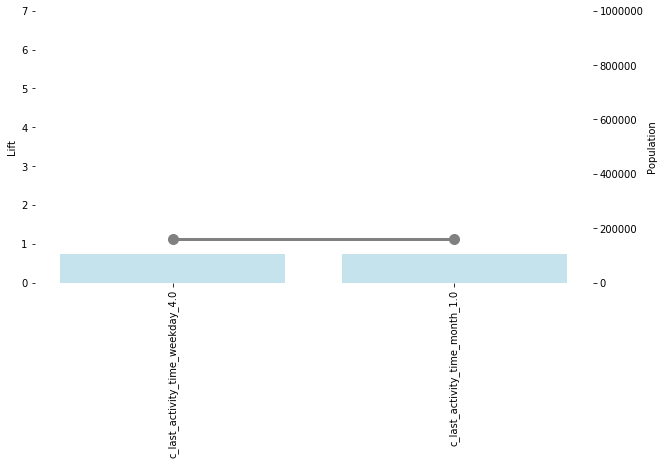

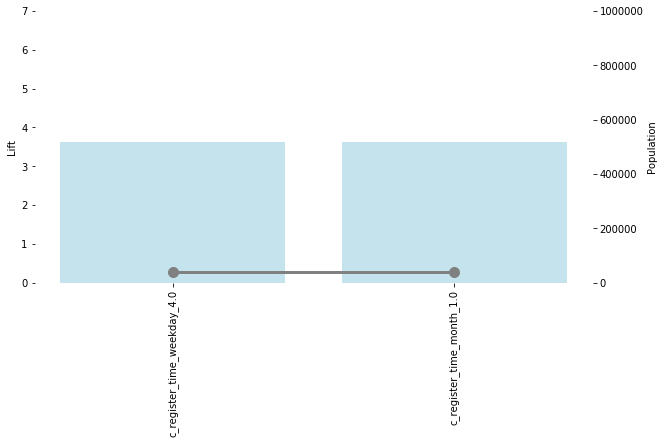

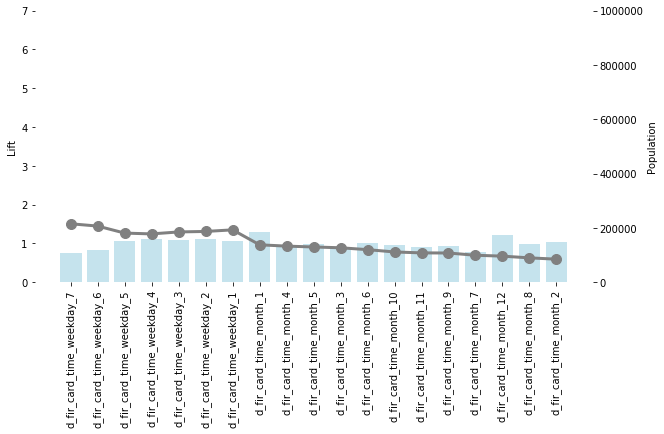

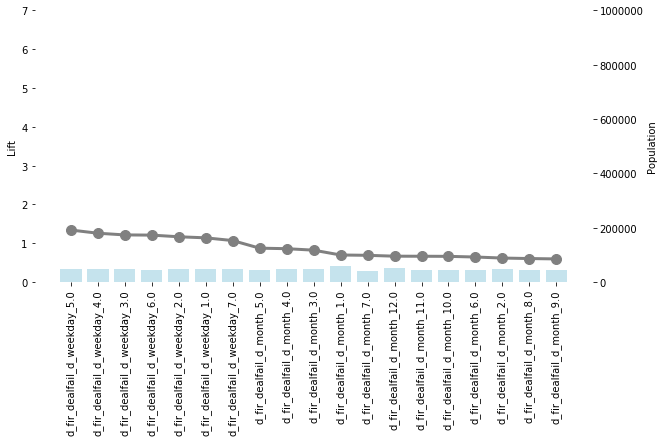

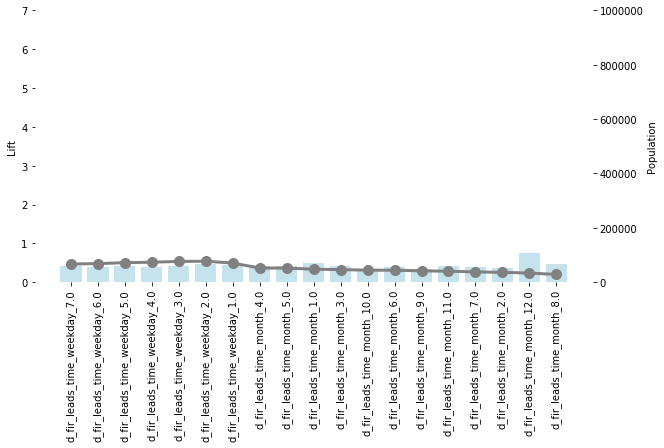

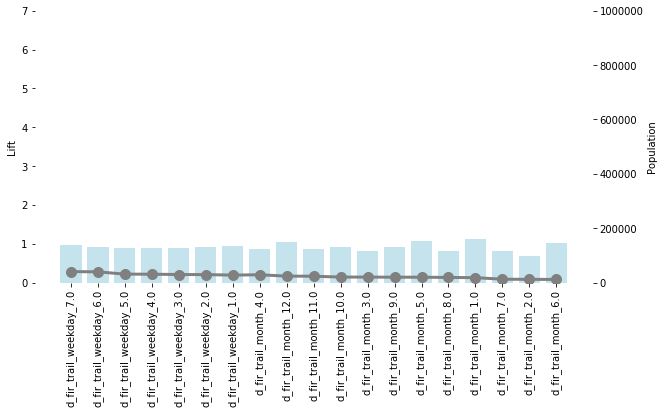

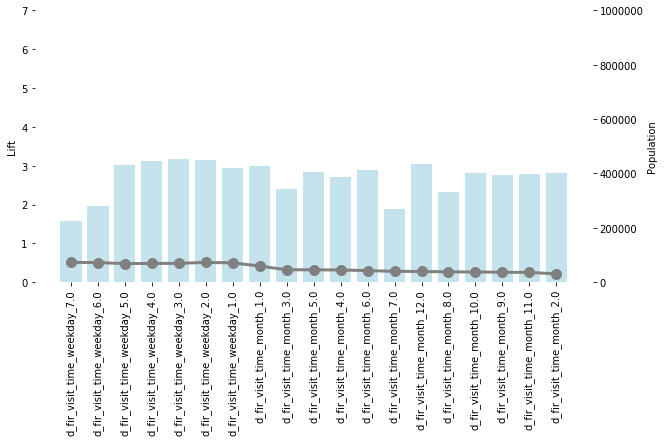

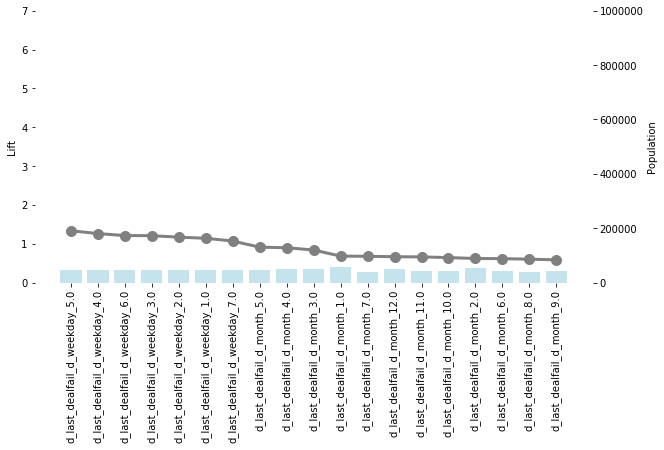

In [46]:
datetime_list = ['c_last_activity_time', 'c_register_time', 'd_fir_card_time', 'd_fir_dealfail_d',  'd_fir_leads_time', 'd_fir_trail',
                 'd_fir_visit_time', 'd_last_dealfail_d']

for col in datetime_list:
    lm_plot(col)

#### Categorical Features

In [ ]:
cat_col = list(lm_others[(lm_others['action'].str.contains('c_')) & (lm_others['action'].str.contains('d_') == False)]['action'])

#### Numerical Features